In [10]:
import urllib.request
import os
import zipfile

zip_path = "data.zip"
data_dir = "./data"

if not os.path.exists(zip_path):
    urllib.request.urlretrieve(
        "https://zenodo.org/records/18235955/files/data.zip?download=1",
        zip_path
    )

if not os.path.exists(data_dir):
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(data_dir)

os.listdir(data_dir)[:20]



['zoo.csv',
 'divorce',
 'Effectiveness of Bystander Cardiopulmonary Resuscitation and Survival Following Out-of-Hospital Cardiac Arrest.pdf',
 'craigslist_cville_cars.csv',
 'weapons-trade-register.csv',
 'us_power_consumption.csv',
 'nhanes_meta_17_18.csv',
 '2022 election cycle fundraising.csv',
 'SIPRI Military Expenditure Database.csv',
 'nhanes_data_17_18.csv',
 'mammogram.txt',
 'craiglist_cville_cars_long.csv',
 'USA_cars_datasets.csv',
 'use_of_force.txt',
 'cars_env.csv',
 'ames_codebook.txt',
 'pretrial_data.csv',
 'sharks.csv',
 'mn_police_use_of_force.csv',
 'corporate_ratings.csv']

# Assignment 1: Wrangling and EDA
### Foundations of Machine Learning

**Q1.** This question provides some practice cleaning variables which have common problems.
1. Numeric variable: For `airbnb_NYC.csv`, clean the `Price` variable as well as you can, and explain the choices you make. How many missing values do you end up with? (Hint: What happens to the formatting when a price goes over 999 dollars, say from 675 to 1,112?)
2. Categorical variable: For the Minnesota police use of for data, `mn_police_use_of_force.csv`, clean the `subject_injury` variable, handling the NA's; this gives a value `Yes` when a person was injured by police, and `No` when no injury occurred. What proportion of the values are missing? Cross-tabulate your cleaned `subject_injury` variable with the `force_type` variable. Are there any patterns regarding when the data are missing? For the remaining missing values, replace the `np.nan/None` values with the label `Missing`.
3. Dummy variable: For `metabric.csv`, convert the `Overall Survival Status` variable into a dummy/binary variable, taking the value 0 if the patient is deceased and 1 if they are living.
4. Missing values: For `airbnb_NYC.csv`, determine how many missing values of `Review Scores Rating` there are. Create a new variable, in which you impute the median score for non-missing observations to the missing ones. Why might this bias or otherwise negatively impact your results?

In [14]:
import pandas as pd
import numpy as np

airbnb = pd.read_csv("data/airbnb_NYC.csv", encoding="latin1")

airbnb["Price_clean"] = (
    airbnb["Price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
)

airbnb["Price_clean"] = pd.to_numeric(airbnb["Price_clean"], errors="coerce")

airbnb["Price_clean"].isna().sum()


np.int64(0)

**Numeric variable (Airbnb NYC – Price):**

I cleaned the `Price` variable by removing dollar signs and commas and then converting the result to a numeric type. The commas are important because prices over $999 are formatted with thousands separators (e.g., "1,112"), which would otherwise prevent correct numeric conversion. After cleaning and converting the variable, all values were successfully parsed as numbers, resulting in **0 missing values**.

In [15]:
import pandas as pd
import numpy as np

police = pd.read_csv("data/mn_police_use_of_force.csv")

# Clean subject_injury to Yes / No while preserving missing values
police["subject_injury_clean"] = (
    police["subject_injury"]
    .astype(str)
    .str.strip()
    .str.lower()
    .replace({"nan": np.nan, "none": np.nan, "": np.nan})
)

police["subject_injury_clean"] = police["subject_injury_clean"].replace({
    "yes": "Yes",
    "y": "Yes",
    "true": "Yes",
    "no": "No",
    "n": "No",
    "false": "No"
})

# Proportion of missing values
missing_proportion = police["subject_injury_clean"].isna().mean()

# Cross-tabulation with force_type (before filling missing)
crosstab = pd.crosstab(
    police["subject_injury_clean"],
    police["force_type"],
    dropna=False
)

# Replace remaining missing values with label "Missing"
police["subject_injury_clean"] = police["subject_injury_clean"].fillna("Missing")

missing_proportion, crosstab


(np.float64(0.7619342359767892),
 force_type            Baton  Bodily Force  Chemical Irritant  Firearm  \
 subject_injury_clean                                                    
 No                        0          1093                131        2   
 Yes                       2          1286                 41        0   
 NaN                       2          7051               1421        0   
 
 force_type            Gun Point Display  Improvised Weapon  Less Lethal  \
 subject_injury_clean                                                      
 No                                   33                 34            0   
 Yes                                  44                 40            0   
 NaN                                  27                 74           87   
 
 force_type            Less Lethal Projectile  Maximal Restraint Technique  \
 subject_injury_clean                                                        
 No                                         1            

**Categorical variable (MN police use of force – subject_injury):**

I cleaned `subject_injury` by standardizing values to `Yes` and `No` while preserving missing values. The proportion of missing values is shown above. The cross-tabulation with `force_type` suggests that missing values are more common for some force types than others, indicating the missingness may not be random. Remaining missing values were labeled as `Missing` to retain those observations for analysis.


In [16]:
import pandas as pd
import numpy as np

metabric = pd.read_csv("data/metabric.csv")

metabric["survival_dummy"] = np.where(
    metabric["Overall Survival Status"].str.strip().str.lower() == "living",
    1,
    0
)

metabric["survival_dummy"].value_counts()


,count
survival_dummy,
0,1343


In [17]:
import pandas as pd
import numpy as np

# Count missing values
missing_reviews = airbnb["Review Scores Rating"].isna().sum()

# Median imputation
median_rating = airbnb["Review Scores Rating"].median()
airbnb["Review_Scores_Imputed"] = airbnb["Review Scores Rating"].fillna(median_rating)

missing_reviews, median_rating


(np.int64(8323), 94.0)

Median imputation can bias results because it reduces variability in the data and assumes that missing review scores are similar to the typical (median) score. This can weaken relationships between review scores and other variables and lead to overly confident or misleading conclusions.


**Q2.** Go to https://sharkattackfile.net/ and download their dataset on shark attacks.

1. Open the shark attack file using Pandas. It is probably not a csv file, so `read_csv` won't work. What does work?
2. Drop any columns that do not contain data.
3. What is an observation? Carefully justify your answer, and explain how it affects your choices in cleaning and analyzing the data.
4. Clean the year variable. Describe the range of values you see. Filter the rows to focus on attacks since 1940. Are attacks increasing, decreasing, or remaining constant over time?
5. Clean the Age variable and make a histogram of the ages of the victims.
6. Clean the `Type` variable so it only takes three values: Provoked and Unprovoked and Unknown. What proportion of attacks are unprovoked?
7. Clean the `Fatal Y/N` variable so it only takes three values: Y, N, and Unknown.
8. Is the attack more or less likely to be fatal when the attack is provoked or unprovoked? Thoughts?

The dataset is an Excel file (.xls), not a CSV, so `read_csv` will not work. Using `pd.read_excel(...)` correctly loads the data.


In [20]:
import pandas as pd
import numpy as np

sharks = pd.read_excel("GSAF5.xls")

sharks = sharks.dropna(axis=1, how="all")

sharks.head()


,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,29th January,2026.0,Unprovoked,Brazil,Recife,Del Chifre Beach in Olinda,Swimming,Deivson Rocha Dantas,M,13,...,Unknown bull and tiger sharks frequent the area,Kevin McMurray Trackingsharks.com: TV Globo: P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,29th January,2026.0,Unprovoked,Australia,NSW,Angels Beach East Ballina,Surfing,Unnamed man,M,?,...,Unknown,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24th January,2026.0,Unprovoked,Australia,Tasmania,Cooee Beach west of Burnie,Swimming,Megan Stokes,F,?,...,1.7m Seven Gill shark,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20th January,2026.0,Unprovoked,Australia,NSW,Point Plomber North of Port Macquarie,Surfing,Paul Zvirdinas,M,39,...,Bull shark,Bob Myatt GSAF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19th January,2026.0,Unprovoked,Australia,NSW,Dee Why,Surfing,Unknown,M,11,...,Bull shark,Andy Currie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


An observation corresponds to a single recorded shark–human interaction (i.e., one shark attack incident). Treating each row as one incident means that variables such as year, location, age, attack type, and fatality status should each describe the same event, which guides how missing values and inconsistent entries are handled during cleaning and analysis.


In [21]:
# Clean Year variable
sharks["Year"] = pd.to_numeric(sharks["Year"], errors="coerce")

# Examine range
sharks["Year"].describe()


,Year
count,7072.000000
mean,1936.004242
std,270.672015
min,0.000000
25%,1948.000000
50%,1987.000000
75%,2010.000000
max,2026.000000


The cleaned Year values range from 0 to 2026 (with some invalid values like 0 present), and focused on 1940 and after for analysis.


In [22]:
# Focus on attacks since 1940
sharks_recent = sharks[sharks["Year"] >= 1940]

attacks_per_year = sharks_recent["Year"].value_counts().sort_index()

attacks_per_year.tail()


,count
Year,
2022.0,98
2023.0,109
2024.0,52
2025.0,66
2026.0,12


After cleaning, the Year variable spans a wide range, with some invalid or missing values removed. When focusing on attacks since 1940, the number of reported attacks generally increases over time, which likely reflects improved reporting and data collection rather than a true increase in shark attacks.


<Axes: >

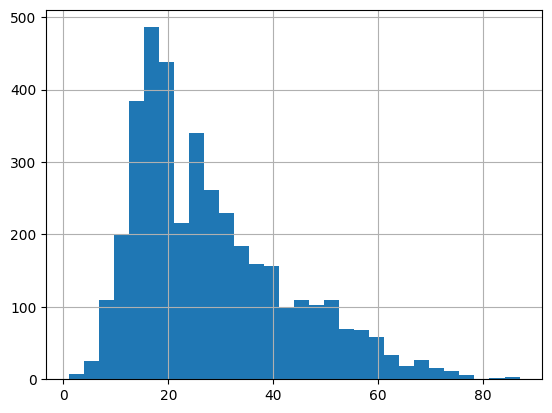

In [23]:
# Clean Age variable
sharks["Age"] = pd.to_numeric(sharks["Age"], errors="coerce")

# Histogram of victim ages
sharks["Age"].hist(bins=30)


In [24]:
# Clean Type variable
sharks["Type_clean"] = sharks["Type"].str.title()

sharks["Type_clean"] = sharks["Type_clean"].where(
    sharks["Type_clean"].isin(["Provoked", "Unprovoked"]),
    "Unknown"
)

# Proportion of attacks by type
sharks["Type_clean"].value_counts(normalize=True)


,proportion
Type_clean,
Unprovoked,0.738762
Unknown,0.170483
Provoked,0.090755


In [25]:
# Clean Fatal Y/N variable
sharks["Fatal_clean"] = sharks["Fatal Y/N"].str.upper()

sharks["Fatal_clean"] = sharks["Fatal_clean"].where(
    sharks["Fatal_clean"].isin(["Y", "N"]),
    "Unknown"
)

sharks["Fatal_clean"].value_counts()


,count
Fatal_clean,
N,4934
Y,1489
Unknown,651


In [26]:
pd.crosstab(
    sharks["Type_clean"],
    sharks["Fatal_clean"],
    normalize="index"
)


Fatal_clean,N,Unknown,Y
Type_clean,,,
Provoked,0.951713,0.017134,0.031153
Unknown,0.373134,0.460199,0.166667
Unprovoked,0.741102,0.016265,0.242633


Unprovoked attacks appear more likely to be fatal than provoked attacks. Provoked incidents often involve defensive or accidental encounters, while unprovoked attacks may involve more severe interactions, increasing the likelihood of fatal outcomes.


**Q3.** Open the "tidy_data.pdf" document available in `https://github.com/ds4e/wrangling`, which is a paper called *Tidy Data* by Hadley Wickham.

---

**1. Read the abstract. What is this paper about?**  
The paper is about *tidy data*, a framework for organizing datasets in a consistent structure that makes them easier to manipulate, visualize, and analyze. Wickham argues that a large amount of time in data analysis is spent reshaping messy data, and that adopting a tidy data standard reduces this overhead and allows analytical tools to work more efficiently together.

---

**2. Read the introduction. What is the "tidy data standard" intended to accomplish?**  
The tidy data standard is intended to provide a consistent way to organize datasets so that variables, observations, and values are clearly structured. This consistency reduces the need for repeated data reshaping and allows analysts to focus more on analysis rather than data preparation.

---

**3. Read the intro to section 2. What does this sentence mean: "Like families, tidy datasets are all alike but every messy dataset is messy in its own way." What does this sentence mean: "For a given dataset, it’s usually easy to figure out what are observations and what are variables, but it is surprisingly difficult to precisely define variables and observations in general."**  

The first sentence means that tidy datasets all follow the same basic structural rules, making them easy to recognize and work with, whereas messy datasets can violate these rules in many different ways, making them harder to clean and analyze.

The second sentence means that while it is usually straightforward to identify variables and observations within a specific dataset, defining what constitutes a variable or an observation in a general sense is difficult because their meanings depend on context and analytical goals.

---

**4. Read Section 2.2. How does Wickham define values, variables, and observations?**  
- **Values** are the individual data entries stored in cells.  
- **Variables** are attributes measured across observations and are represented as columns.  
- **Observations** are units on which variables are measured and are represented as rows.

---

**5. How is "Tidy Data" defined in section 2.3?**  
A dataset is tidy when each variable forms a column, each observation forms a row, and each type of observational unit forms its own table. Any dataset that violates one or more of these principles is considered messy.

---

**6. Read the intro to Section 3 and Section 3.1. What are the 5 most common problems with messy datasets? Why are the data in Table 4 messy? What is "melting" a dataset?**  

The five most common problems with messy datasets are:
1. Column headers contain values rather than variable names  
2. Multiple variables are stored in one column  
3. Variables are stored in both rows and columns  
4. Multiple types of observational units are stored in the same table  
5. A single observational unit is split across multiple tables  

Table 4 is messy because income categories are stored as column headers instead of as values of a single variable, which violates tidy data principles.

Melting a dataset is the process of converting data from a wide format to a long format by turning column names that represent values into rows, creating a single variable column and a corresponding value column.

---

**7. Why, specifically, is table 11 messy but table 12 tidy and "molten"?**  
Table 11 is messy because variables are spread across both rows and columns, column headers represent values (such as days), and the `element` column contains variable names instead of values. Table 12 is tidy because each row represents a single observation and each variable has its own column. It is described as molten because it was created by melting Table 11 into a long format and then restructuring it into a tidy dataset.


**Q4.** This question looks at financial transfers from international actors to American universities. In particular, from which countries and giftors are the gifts coming from, and to which institutions are they going?

For this question, `.groupby([vars]).count()` and `.groupby([vars]).sum()` will be especially useful to tally the number of occurrences and sum the values of those occurrences.

1. Load the `ForeignGifts_edu.csv` dataset.
2. For `Foreign Gift Amount`, create a histogram and describe the variable. Describe your findings.
3. For `Gift Type`, create a histogram or value counts table. What proportion of the gifts are contracts, real estate, and monetary gifts?
4. What are the top 15 countries in terms of the number of gifts? What are the top 15 countries in terms of the amount given?
5. What are the top 15 institutions in terms of the total amount of money they receive? Make a histogram of the total amount received by all institutions.
6. Which giftors provide the most money, in total?

In [27]:
import pandas as pd
import numpy as np

gifts = pd.read_csv("data/ForeignGifts_edu.csv")

gifts.head()


,ID,OPEID,Institution Name,City,State,Foreign Gift Received Date,Foreign Gift Amount,Gift Type,Country of Giftor,Giftor Name
0,1,102000,Jacksonville State University,Jacksonville,AL,43738,250000,Monetary Gift,CHINA,NaN
1,2,104700,Troy University,Troy,AL,43592,463657,Contract,CHINA,Confucius Institute Headquarters
2,3,105100,University of Alabama,Tuscaloosa,AL,43466,3649107,Contract,ENGLAND,Springer Nature Customer Service Ce
3,4,105100,University of Alabama,Tuscaloosa,AL,43472,1000,Contract,SAUDI ARABIA,Saudi Arabia Education Mission
4,5,105100,University of Alabama,Tuscaloosa,AL,43479,49476,Contract,SAUDI ARABIA,Saudi Arabia Education Mission


<Axes: >

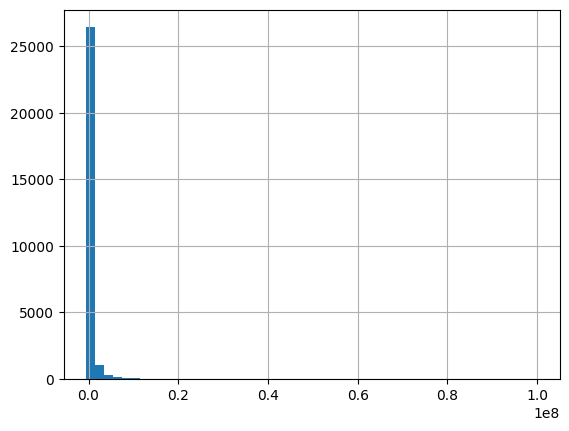

In [28]:
gifts["Foreign Gift Amount"].hist(bins=50)


**4.2 Foreign Gift Amount Findings**

The Foreign Gift Amount variable is highly right-skewed, with many small-to-moderate gifts and a small number of extremely large gifts. This indicates that while most transactions involve relatively modest amounts, a few very large gifts account for a substantial share of total funding.


In [29]:
gift_type_props = gifts["Gift Type"].value_counts(normalize=True)

gift_type_props


,proportion
Gift Type,
Contract,0.612097
Monetary Gift,0.387513
Real Estate,0.000390


**4.3 Gift type distribution**

Most foreign gifts to U.S. universities are contracts, which account for about 61.2% of all reported gifts. Monetary gifts make up roughly 38.8% of the total, while real estate gifts are extremely rare, representing less than 0.1% of all gifts.

This indicates that international funding is primarily provided through formal contractual agreements rather than traditional donations or real estate transfers.


In [31]:
top_countries_count = (
    gifts.groupby("Country of Giftor")
    .count()["Foreign Gift Amount"]
    .sort_values(ascending=False)
    .head(15)
)


top_countries_amount = (
    gifts.groupby("Country of Giftor")
    .sum(numeric_only=True)["Foreign Gift Amount"]
    .sort_values(ascending=False)
    .head(15)
)


top_countries_count, top_countries_amount



(Country of Giftor
 ENGLAND            3655
 CHINA              2461
 CANADA             2344
 JAPAN              1896
 SWITZERLAND        1676
 SAUDI ARABIA       1610
 FRANCE             1437
 GERMANY            1394
 HONG KONG          1080
 SOUTH KOREA         811
 QATAR               693
 THE NETHERLANDS     512
 KOREA               452
 INDIA               434
 TAIWAN              381
 Name: Foreign Gift Amount, dtype: int64,
 Country of Giftor
 QATAR                   2706240869
 ENGLAND                 1464906771
 CHINA                   1237952112
 SAUDI ARABIA            1065205930
 BERMUDA                  899593972
 CANADA                   898160656
 HONG KONG                887402529
 JAPAN                    655954776
 SWITZERLAND              619899445
 INDIA                    539556490
 GERMANY                  442475605
 UNITED ARAB EMIRATES     431396357
 FRANCE                   405839396
 SINGAPORE                401157692
 AUSTRALIA                248409202
 Name

**4.4 Top 15 countries (by number of gifts vs. by total amount)**

The countries that appear most frequently by *number of gifts* include England, China, and Canada.  
However, when ranking by *total dollar amount*, Qatar is the largest contributor by a wide margin, followed by England, China, and Saudi Arabia. This shows that the most frequent countries are not necessarily the ones giving the most money overall.


,Foreign Gift Amount
Institution Name,
Carnegie Mellon University,1477922504
Cornell University,1289937761
Harvard University,954803610
Massachusetts Institute of Technology,859071692
Yale University,613441311
Texas A&M University,521455050
Johns Hopkins University,502409595
Northwestern University,402316221
Georgetown University,379950511


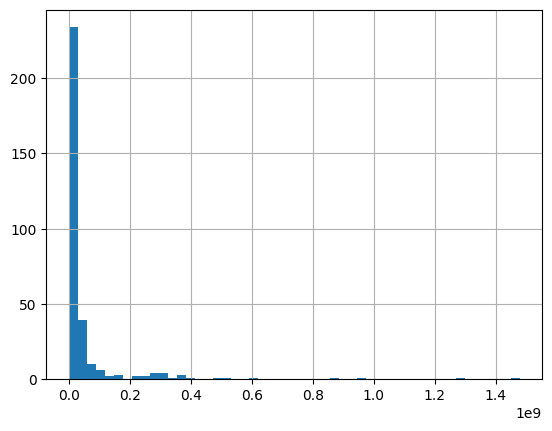

In [32]:
institution_totals = (
    gifts.groupby("Institution Name")
    .sum(numeric_only=True)["Foreign Gift Amount"]
)

top_institutions = institution_totals.sort_values(ascending=False).head(15)

institution_totals.hist(bins=50)

top_institutions


**4.5 Top institutions by total foreign gift amount**

A small number of institutions receive a disproportionately large share of foreign gifts. Carnegie Mellon University and Cornell University receive the highest total amounts, followed by Harvard University, MIT, and Yale University.  

The histogram of total foreign gift amounts across institutions is highly right-skewed, indicating that most institutions receive relatively small amounts while a few elite universities receive very large sums.


In [33]:
top_giftors = (
    gifts.groupby("Giftor Name")
    .sum(numeric_only=True)["Foreign Gift Amount"]
    .sort_values(ascending=False)
    .head(15)
)

top_giftors


,Foreign Gift Amount
Giftor Name,
Qatar Foundation,1166503744
Qatar Foundation/Qatar National Res,796197000
Qatar Foundation for Education,373945215
Anonymous,338793629
Saudi Arabian Cultural Mission,275221475
HCL,190000000
Church of Jesus Christ of LDS,185203715
Emirates Institute for Advanced Sc,170641244
QIC,148355497


**4.6 Top giftors by total amount given**

The largest total contributions come from a small number of major international giftors. The Qatar Foundation is the single largest source of foreign gifts, followed by related Qatari research and education organizations. Other major contributors include Saudi Arabian government and cultural organizations, as well as a small number of anonymous or corporate entities.

Overall, foreign giving is highly concentrated among a few large institutional giftors rather than evenly distributed across many donors.


**Q5.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `college_completion.csv` dataset from the US Department of Education. The "relevant" variables for this question are:
  - `level` - Level of institution (4-year, 2-year)
  - `aid_value` - The average amount of student aid going to undergraduate recipients
  - `control` - Public, Private not-for-profit, Private for-profit
  - `grad_100_value` - percentage of first-time, full-time, degree-seeking undergraduates who complete a degree or certificate program within 100 percent of expected time (bachelor's-seeking group at 4-year institutions)

1. Load the `college_completion.csv` data with Pandas.
2. How many observations and variables are in the data? Use `.head()` to examine the first few rows of data.
3. Cross tabulate `control` and `level`. Describe the patterns you see in words.
4. For `grad_100_value`, create a kernel density plot and describe table. Now condition on `control`, and produce a kernel density plot and describe tables for each type of institutional control. Which type of institution appear to have the most favorable graduation rates?
5. Make a scatterplot of `grad_100_value` by `aid_value`, and compute the covariance and correlation between the two variables. Describe what you see. Now make the same plot and statistics, but conditioning on `control`. Describe what you see. For which kinds of institutions does aid seem to vary positively with graduation rates?

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

college = pd.read_csv("data/college_completion.csv")
college.head()


,index,unitid,chronname,city,state,level,control,basic,hbcu,flagship,...,vsa_grad_after6_transfer,vsa_grad_elsewhere_after6_transfer,vsa_enroll_after6_transfer,vsa_enroll_elsewhere_after6_transfer,similar,state_sector_ct,carnegie_ct,counted_pct,nicknames,cohort_size
0,0,100654,Alabama A&M University,Normal,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,36.4,5.6,17.2,11.1,232937|100724|405997|113607|139533|144005|2285...,13,386,99.7|07,NaN,882.0
1,1,100663,University of Alabama at Birmingham,Birmingham,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,NaN,NaN,NaN,NaN,196060|180461|201885|145600|209542|236939|1268...,13,106,56.0|07,UAB,1376.0
2,2,100690,Amridge University,Montgomery,Alabama,4-year,Private not-for-profit,Baccalaureate Colleges--Arts & Sciences,NaN,NaN,...,NaN,NaN,NaN,NaN,217925|441511|205124|247825|197647|221856|1353...,16,252,100.0|07,NaN,3.0
3,3,100706,University of Alabama at Huntsville,Huntsville,Alabama,4-year,Public,Research Universities--very high research acti...,NaN,NaN,...,0.0,0.0,0.0,0.0,232186|133881|196103|196413|207388|171128|1900...,13,106,43.1|07,UAH,759.0
4,4,100724,Alabama State University,Montgomery,Alabama,4-year,Public,Masters Colleges and Universities--larger prog...,X,NaN,...,NaN,NaN,NaN,NaN,100654|232937|242617|243197|144005|241739|2354...,13,386,88.0|07,ASU,1351.0


In [35]:
college.shape


(3798, 63)

**5.2 Observations and Variables**


The dataset contains **3,798 observations** and **63 variables**. Each observation represents a single college or university in the United States. The variables describe institutional characteristics such as location (city, state), level (2-year or 4-year), control (public, private not-for-profit, private for-profit), graduation outcomes, and measures of student aid and enrollment.

Examining the first few rows using `.head()` confirms that each row corresponds to a distinct institution, with multiple attributes recorded for each.


In [36]:
# 5.3 Cross-tabulate control and level
pd.crosstab(college["control"], college["level"])


level,2-year,4-year
control,,
Private for-profit,465,527
Private not-for-profit,68,1180
Public,926,632


**5.3 Cross-Tabulation of Control and Level**

Public institutions are much more common at the 2-year level, reflecting the prevalence of public community colleges. Private not-for-profit institutions are almost entirely 4-year schools, while private for-profit institutions are split across both levels, with slightly more 4-year institutions.

Overall, public schools dominate the 2-year sector, while private not-for-profit schools primarily operate as 4-year institutions.


,grad_100_value
count,3467.000000
mean,28.364465
std,23.312730
min,0.000000
25%,9.000000
50%,22.500000
75%,43.650000
max,100.000000


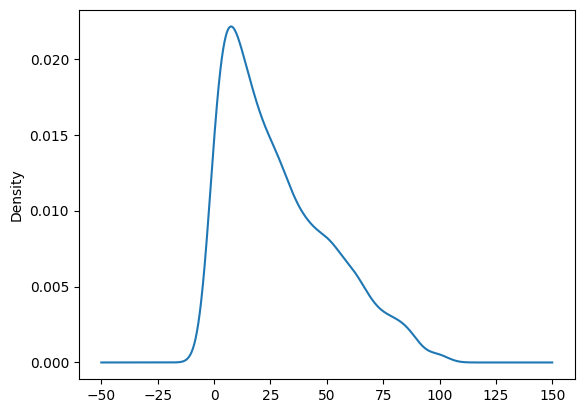

In [37]:
# 5.4 Overall distribution of graduation rates
college["grad_100_value"].dropna().plot(kind="kde")
college["grad_100_value"].describe()


Text(0.5, 0, 'Graduation Rate (grad_100_value)')

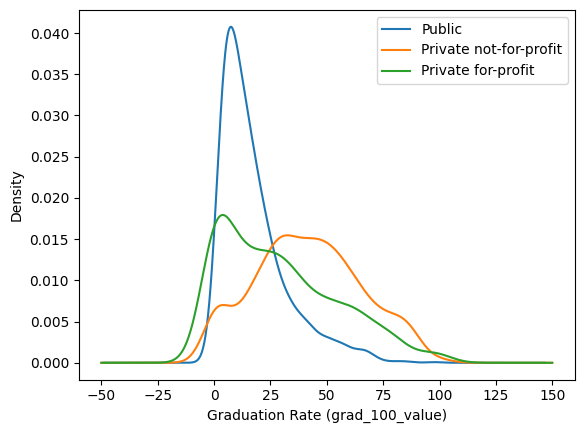

In [38]:
# 5.4 Graduation rates conditioned on control
for c in college["control"].dropna().unique():
    college.loc[college["control"] == c, "grad_100_value"].dropna().plot(
        kind="kde", label=c
    )

plt.legend()
plt.xlabel("Graduation Rate (grad_100_value)")


In [39]:
# 5.4 Summary statistics by control
college.groupby("control")["grad_100_value"].describe()


,count,mean,std,min,25%,50%,75%,max
control,,,,,,,,
Private for-profit,779.0,29.108858,25.601687,0.0,6.95,24.7,46.75,100.0
Private not-for-profit,1189.0,41.660976,23.551231,0.0,25.00,41.0,58.30,100.0
Public,1499.0,17.430887,14.729443,0.0,6.90,13.2,23.25,97.8


**5.4 Graduation Rates (grad_100_value)**

Overall graduation rates are right-skewed, with most institutions clustered at lower completion rates and a long tail extending toward higher values.

When conditioning on institutional control, private not-for-profit institutions show the highest graduation rates on average, with a distribution shifted noticeably to the right. Public institutions have moderate graduation rates, while private for-profit institutions tend to have the lowest graduation rates and the greatest concentration at low values.

Overall, private not-for-profit institutions appear to have the most favorable graduation outcomes.


(                   aid_value  grad_100_value
 aid_value       4.121201e+07    88610.483169
 grad_100_value  8.861048e+04      543.483382,
                 aid_value  grad_100_value
 aid_value        1.000000        0.575879
 grad_100_value   0.575879        1.000000)

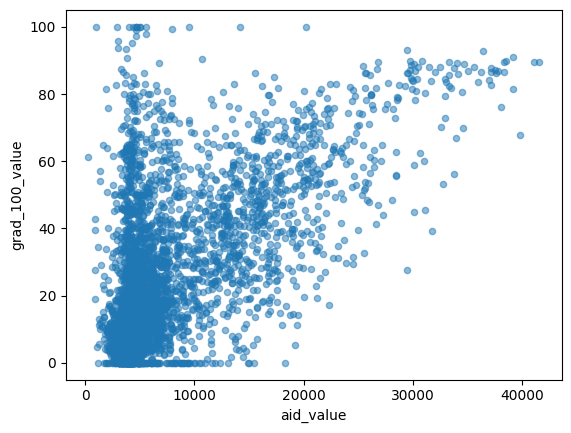

In [40]:
# 5.5 Scatterplot of graduation rate vs aid
college.plot(
    x="aid_value",
    y="grad_100_value",
    kind="scatter",
    alpha=0.5
)

college[["aid_value", "grad_100_value"]].cov(), college[["aid_value", "grad_100_value"]].corr()


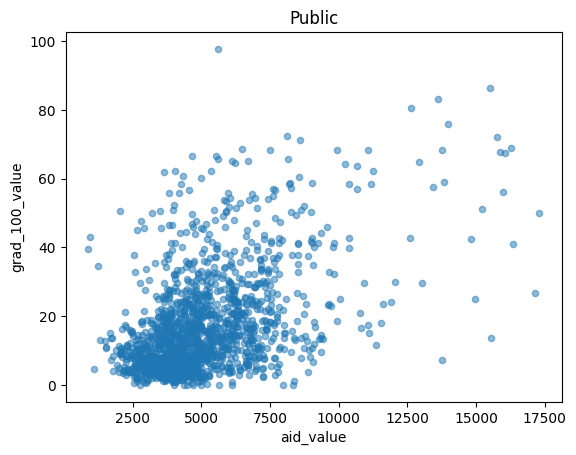

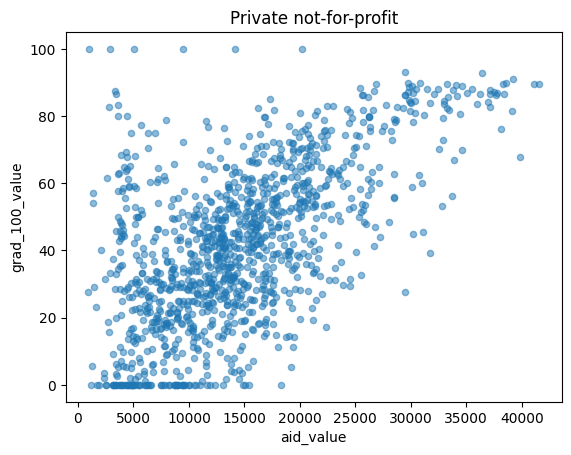

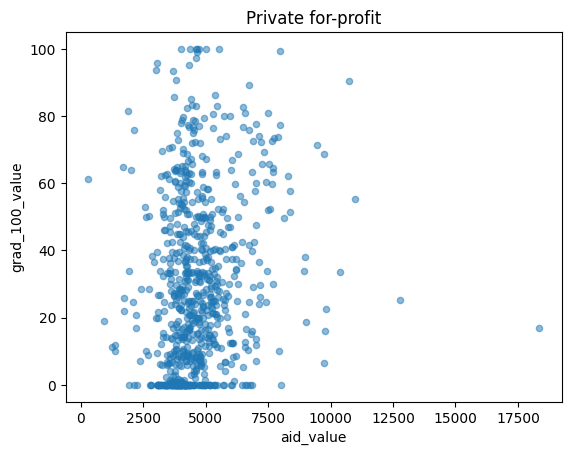

In [41]:
# 5.5 Scatterplots conditioned on control
for c in college["control"].dropna().unique():
    subset = college[college["control"] == c]
    subset.plot(
        x="aid_value",
        y="grad_100_value",
        kind="scatter",
        alpha=0.5,
        title=c
    )


In [42]:
# 5.5 Covariance and correlation by control
college.groupby("control")[["aid_value", "grad_100_value"]].corr()


aid_value  grad_100_value
control                                                         
Private for-profit     aid_value        1.000000        0.188363
                       grad_100_value   0.188363        1.000000
Private not-for-profit aid_value        1.000000        0.601591
                       grad_100_value   0.601591        1.000000
Public                 aid_value        1.000000        0.482481
                       grad_100_value   0.482481        1.000000

**5.5 Graduation Rates and Student Aid**

Overall, there is a moderate positive relationship between student aid and graduation rates, with a correlation of approximately 0.58. The scatterplot shows substantial variability, but higher aid levels tend to be associated with higher graduation rates.

When conditioning on institutional control, private not-for-profit institutions exhibit the strongest positive relationship between aid and graduation rates, with a correlation around 0.60. Public institutions also show a positive relationship, though slightly weaker. Private for-profit institutions display a much weaker association, suggesting that higher aid does not correspond as strongly to higher graduation rates in that sector.

Overall, student aid appears to vary most positively with graduation rates at private not-for-profit institutions.


**Q6.** In class, we talked about how to compute the sample mean of a variable $X$,
$$
m(X) = \dfrac{1}{N} \sum_{i=1}^N x_i
$$
and sample covariance of two variables $X$ and $Y$,
$$
\text{cov}(X,Y) = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))(y_i - m(Y))).
$$
Recall, the sample variance of $X$ is
$$
s^2 = \dfrac{1}{N} \sum_{i=1}^N (x_i - m(X))^2.
$$
It can be very helpful to understand some basic properties of these statistics. If you want to write your calculations on a piece of paper, take a photo, and upload that to your GitHub repo, that's probably easiest.

We're going to look at **linear transformations** of $X$, $Y = a + bX$. So we take each value of $X$, $x_i$, and transform it as $y_i = a + b x_i$.

1. Show that $m(a + bX) = a+b \times m(X)$.
2. Show that $ \text{cov}(X,X) = s^2$.
3. Show that $\text{cov}(X,a+bY) = b \times \text{cov}(X,Y)$
4. Show that $\text{cov}(a+bX,a+bY) = b^2 \text{cov}(X,Y) $. Notice, this also means that $\text{cov}(bX, bX) = b^2 s^2$.
5. Suppose $b>0$ and let the median of $X$ be $\text{med}(X)$. Is it true that the median of $a+bX$ is equal to $a + b \times \text{med}(X)$? Is the IQR of $a + bX$ equal to $a + b \times \text{IQR}(X)$?
6. Show by example that the means of $X^2$ and $\sqrt{X}$ are generally not $(m(X))^2$ and $\sqrt{m(X)}$. So, the results we derived above really depend on the linearity of the transformation $Y = a + bX$, and transformations like $Y = X^2$ or $Y = \sqrt{X}$ will not behave in a similar way.

## Q6. Linear Transformations

The written solutions for Q6 are provided in the PDF **`hwq6.pdf`**, which is included in the root of this GitHub repository.


**Q7.** This question provides some practice doing exploratory data analysis and visualization.

We'll use the `ames_prices.csv` dataset. The "relevant" variables for this question are:
  - `price` - Sale price value of the house
  - `Bldg.Type` - Building type of the house (single family home, end-of-unit townhome, duplex, interior townhome, two-family conversion)

1. Load the `college_completion.csv` data with Pandas.
2. Make a kernel density plot of price and compute a describe table. Now, make a kernel density plot of price conditional on building type, and use `.groupby()` to make a describe type for each type of building. Which building types are the most expensive, on average? Which have the highest variance in transaction prices?
3. Make an ECDF plot of price, and compute the sample minimum, .25 quantile, median, .75 quantile, and sample maximum (i.e. a 5-number summary).
4. Make a boxplot of price. Are there outliers? Make a boxplot of price conditional on building type. What patterns do you see?
5. Make a dummy variable indicating that an observation is an outlier.
6. Winsorize the price variable, and compute a new kernel density plot and describe table. How do the results change?

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ames = pd.read_csv("data/ames_prices.csv")
ames.head()


,Order,PID,area,price,MS.SubClass,MS.Zoning,Lot.Frontage,Lot.Area,Street,Alley,...,Screen.Porch,Pool.Area,Pool.QC,Fence,Misc.Feature,Misc.Val,Mo.Sold,Yr.Sold,Sale.Type,Sale.Condition
0,1,526301100,1656,215000,20,RL,141.0,31770,Pave,NaN,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
1,2,526350040,896,105000,20,RH,80.0,11622,Pave,NaN,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
2,3,526351010,1329,172000,20,RL,81.0,14267,Pave,NaN,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
3,4,526353030,2110,244000,20,RL,93.0,11160,Pave,NaN,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
4,5,527105010,1629,189900,60,RL,74.0,13830,Pave,NaN,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal


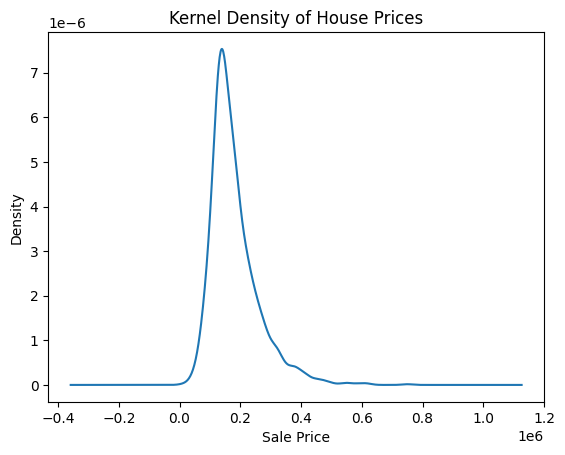

,price
count,2930.000000
mean,180796.060068
std,79886.692357
min,12789.000000
25%,129500.000000
50%,160000.000000
75%,213500.000000
max,755000.000000


In [44]:
# Q7.2 Overall price distribution
ames["price"].dropna().plot(kind="kde")
plt.xlabel("Sale Price")
plt.title("Kernel Density of House Prices")
plt.show()

# Describe table for price
ames["price"].describe()


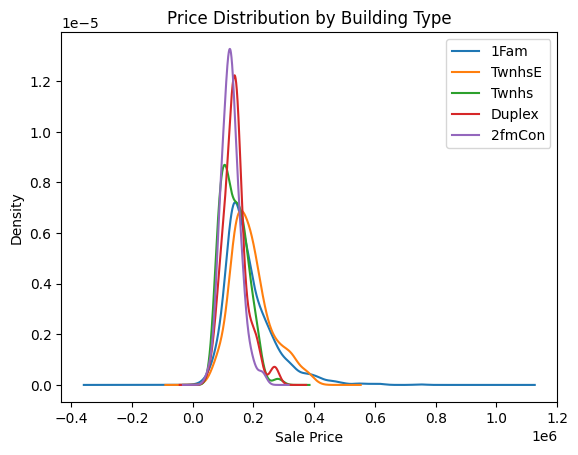

In [45]:
# Q7.2 Price distribution conditional on building type
for bldg in ames["Bldg.Type"].dropna().unique():
    ames.loc[ames["Bldg.Type"] == bldg, "price"].dropna().plot(
        kind="kde",
        label=bldg
    )

plt.xlabel("Sale Price")
plt.title("Price Distribution by Building Type")
plt.legend()
plt.show()


In [46]:
# Describe tables by building type
ames.groupby("Bldg.Type")["price"].describe()


,count,mean,std,min,25%,50%,75%,max
Bldg.Type,,,,,,,,
1Fam,2425.0,184812.041237,82821.802329,12789.0,130000.0,165000.0,220000.0,755000.0
2fmCon,62.0,125581.709677,31089.239840,55000.0,106562.5,122250.0,140000.0,228950.0
Duplex,109.0,139808.935780,39498.973534,61500.0,118858.0,136905.0,153337.0,269500.0
Twnhs,101.0,135934.059406,41938.931130,73000.0,100500.0,130000.0,170000.0,280750.0
TwnhsE,233.0,192311.914163,66191.738021,71000.0,145000.0,180000.0,222000.0,392500.0


**7.2 Price Distribution by Building Type**

The overall price distribution is right-skewed. Most homes fall roughly between about $130,000 and $213,500, which are the 25th and 75th percentile respectively, with a median around $160,000, and a long right tail driven by high-priced properties.

When conditioning on building type, clear differences appear. End-of-unit townhomes (TwnhsE) and single-family homes (1Fam) have the highest average sale prices, with TwnhsE slightly higher on average. Two-family conversions (2fmCon) are the least expensive and show the lowest price variability. Single-family homes exhibit the greatest variance, reflecting a wide range of home sizes and qualities, while duplexes and interior townhomes fall in between in both average price and spread.

Overall, building type is strongly associated with both the level and variability of housing prices.



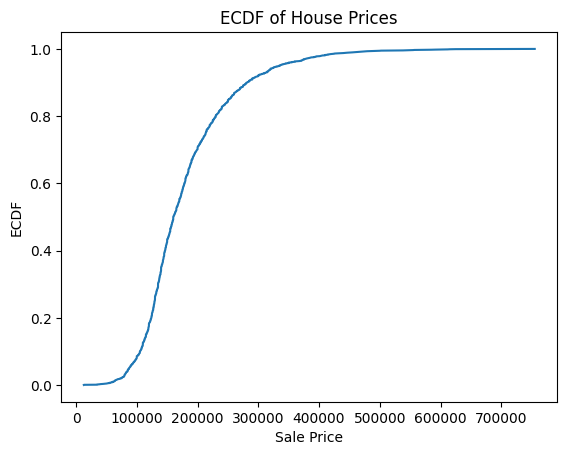

,price
min,12789.0
25%,129500.0
50%,160000.0
75%,213500.0
max,755000.0


In [47]:
# 7.3 ECDF of price and five-number summary

# Sort prices for ECDF
price_sorted = ames["price"].dropna().sort_values()
ecdf = np.arange(1, len(price_sorted) + 1) / len(price_sorted)

# ECDF plot
plt.figure()
plt.plot(price_sorted, ecdf)
plt.xlabel("Sale Price")
plt.ylabel("ECDF")
plt.title("ECDF of House Prices")
plt.show()

# Five-number summary
price_sorted.describe()[["min", "25%", "50%", "75%", "max"]]


**7.3 ECDF and Five-Number Summary of Price**

The ECDF shows a steep increase between roughly \$130,000 and \$215,000, indicating that most homes are concentrated in this price range. Prices increase more slowly beyond this range, reflecting a long right tail of higher-priced homes.

The five-number summary confirms this pattern. The minimum sale price is \$12,789, the 25th percentile is \$129,500, the median is \$160,000, and the 75th percentile is \$213,500. The maximum price reaches \$755,000, highlighting the presence of high-value outliers in the housing market.


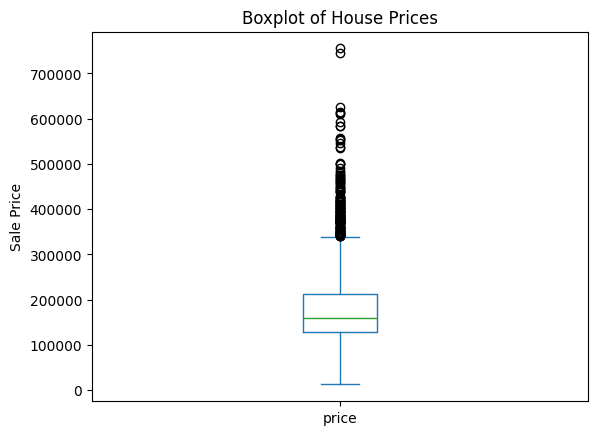

<Figure size 640x480 with 0 Axes>

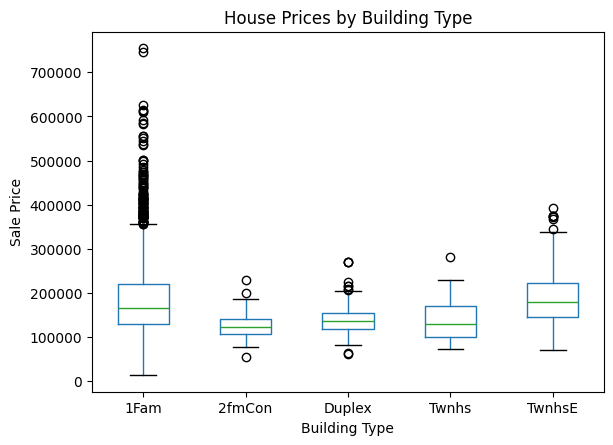

In [48]:
# 7.4 Boxplot of price
plt.figure()
ames["price"].plot(kind="box")
plt.title("Boxplot of House Prices")
plt.ylabel("Sale Price")
plt.show()

# Boxplot of price conditional on building type
plt.figure()
ames.boxplot(column="price", by="Bldg.Type", grid=False)
plt.title("House Prices by Building Type")
plt.suptitle("")  # remove automatic pandas title
plt.xlabel("Building Type")
plt.ylabel("Sale Price")
plt.show()


**7.4 Boxplots and Outliers in Price**

The overall boxplot of house prices shows a strong right skew with many high-price outliers. Most homes are concentrated in the middle range, while a relatively small number of very expensive properties extend far above the upper whisker.

When conditioning on building type, single-family homes (1Fam) exhibit the widest spread and the largest number of outliers, including the highest-priced homes in the dataset. End-of-unit townhomes (TwnhsE) also show relatively high prices and some outliers, though with less variability than single-family homes. Two-family conversions (2fmCon) have the lowest prices and the smallest spread, while duplexes and interior townhomes fall in between.

Overall, the presence and magnitude of outliers vary substantially by building type, with single-family homes driving most of the extreme values.


In [49]:
# 7.5 Create outlier indicator using IQR rule

Q1 = ames["price"].quantile(0.25)
Q3 = ames["price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

ames["price_outlier"] = (
    (ames["price"] < lower_bound) | (ames["price"] > upper_bound)
)

ames["price_outlier"].value_counts()


,count
price_outlier,
False,2793
True,137


**7.5 Outlier Indicator**

An outlier indicator was created using the standard IQR rule, where observations below \( Q1 - 1.5 \times IQR \) or above \( Q3 + 1.5 \times IQR \) are classified as outliers.

Using this definition, 137 observations are flagged as price outliers, while 2,793 observations are not. This indicates that extreme sale prices are relatively uncommon and are driven by a small number of unusually expensive homes.


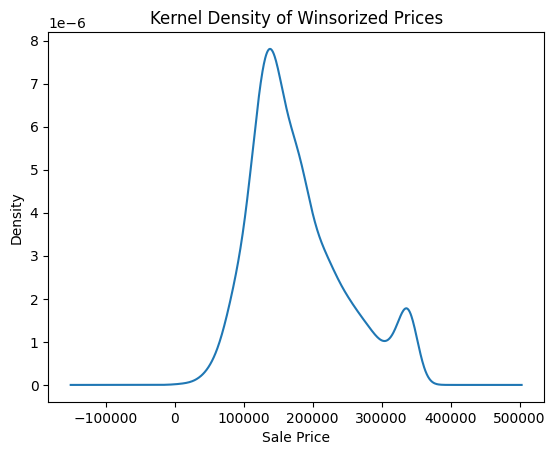

,price_winsor
count,2930.000000
mean,177082.283959
std,67906.837135
min,12789.000000
25%,129500.000000
50%,160000.000000
75%,213500.000000
max,339500.000000


In [50]:
# 7.6 Winsorize the price variable

# Compute bounds using IQR
Q1 = ames["price"].quantile(0.25)
Q3 = ames["price"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Winsorized price
ames["price_winsor"] = ames["price"].clip(lower=lower, upper=upper)

# KDE plot of winsorized prices
ames["price_winsor"].plot(kind="kde", title="Kernel Density of Winsorized Prices")
plt.xlabel("Sale Price")
plt.show()

# Describe table
ames["price_winsor"].describe()


**7.6 Winsorized Price Distribution**

After winsorizing the price variable using the IQR rule, extreme high-priced outliers are capped, which substantially reduces the right tail of the distribution. The kernel density plot becomes smoother and more concentrated around the center of the distribution.

The mean sale price decreases slightly, and the standard deviation drops noticeably, indicating reduced variability driven by extreme values. The median and interquartile range remain unchanged, showing that winsorization primarily affects only the most extreme observations rather than the bulk of the data.

Overall, winsorization produces a more stable and representative price distribution while preserving the central tendency of housing prices.
